# ConvLSTM model

Import libraries and modules.

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

C:\Users\Lucas\Documents\GitHub\FLOOD_group2\models
C:\Users\Lucas\Documents\GitHub\FLOOD_group2


In [28]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Enable interactive widgets in Jupyter Notebook
%matplotlib widget
import torch.nn as nn
# import torch.nn.functional as F

# from numba import jit, prange
# from PIL import Image
import importlib  
from torch.utils.data.dataset import random_split
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# from matplotlib.colors import TwoSlopeNorm

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from pre_processing.encode_decode_csv import decode_from_csv
from post_processing.cool_animation import plot_animation

Check if GPU is available.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [4]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

**Please note**: 
\
inputs and targets in <code>train_val</code> are stored not in the original manner. 

index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 96, 2, 64, 64])


In [12]:
# first position is the samples, second decides between inputs or targets, notice new shape of inputs
train_dataset[0][0].shape

torch.Size([1, 4, 64, 64])

In [ ]:
# test dataset 1
test_dataset1 = decode_from_csv(test1)

In [ ]:
# test dataset 2
test_dataset2 = decode_from_csv(test2)

In [ ]:
# test dataset 3
test_dataset3 = decode_from_csv(test3)

Text(0.5, 1.0, 'Water Depth time step 0')

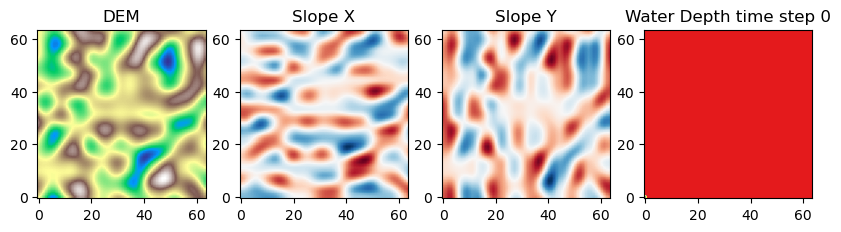

In [13]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 0

axs[0].imshow(train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[numb][0][0][1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(train_dataset[numb][0][0][2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

axs[3].imshow(train_dataset[numb][0][0][3].cpu(), cmap='Set1', origin='lower')
axs[3].set_title('Water Depth time step 0')

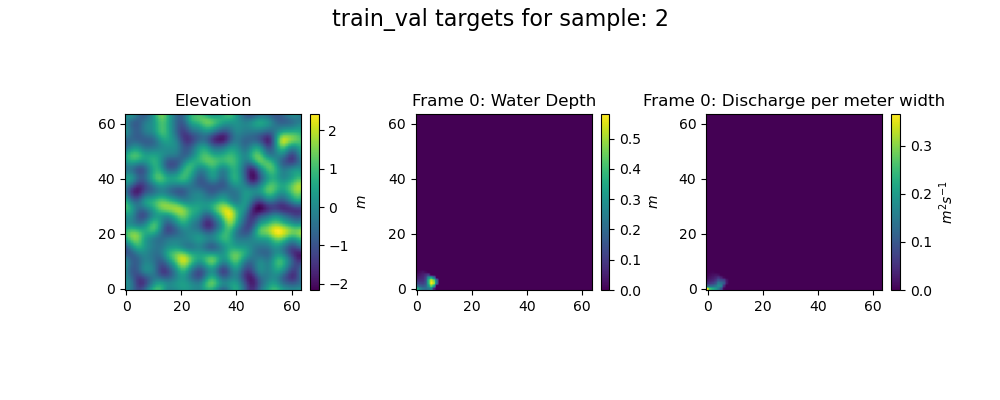

In [29]:
# animate 
plot_animation(2, train_dataset, train_val, False)

In [ ]:
# # Save the animation as a gif
# ani.save('example.gif', writer='Pillow', fps=20)

In [ ]:
def normalize_in_or_tar(in_or_tar, scaler_x, scaler_y):
    if len(in_or_tar.shape) == 4: # inputs, only use scalar x  
        min_var, max_var = scaler_x.data_min_[0], scaler_x.data_max_[0]
    elif len(in_or_tar.shape) == 5: # targets, only use scalar y
        min_var, max_var = scaler_y.data_min_[0], scaler_y.data_max_[0]
    else:
        raise Exception("Something is wrong with encoder/decoder")
    normalized_in_or_out = []
    for idx in range(in_or_tar.shape[0]):
        var = in_or_tar[idx]
        norm_var = (var - min_var) / (max_var - min_var)
        normalized_in_or_out.append(norm_var)
    return torch.stack(normalized_in_or_out, dim=0)

In [ ]:
# Normalize the inputs and targets using training dataset
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

for idx in range(inputs.shape[0]):
    scaler_x.partial_fit(inputs[idx].reshape(inputs.shape[1], -1).T.cpu())
    scaler_y.partial_fit(targets[idx].reshape(targets.shape[1], -1).T.cpu())

normalized_inputs = normalize_in_or_tar(inputs, scaler_x, scaler_y)
normalized_inputs = normalized_inputs.unsqueeze(2) # new shape to make the model understand there is only one timestep
normalized_targets = normalize_in_or_tar(targets, scaler_x, scaler_y)

In [ ]:
# create a dataset to split randomly for train and val
# place timesteps in index position 1, features position 2, I think this is what convlstm is expecting
my_dataset = TensorDataset(normalized_inputs.permute(0, 2, 1, 3, 4), normalized_targets.permute(0, 2, 1, 3, 4))

In [ ]:
my_dataset[79][0].shape # first position is the samples, second decides between inputs or targets, notice new shape of inputs

In [ ]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * inputs.shape[0])
val_size = inputs.shape[0] - train_size
train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])

In [ ]:
# Model, check, not sure num_layers is the expected amount of outputs
model = ConvLSTM(input_dim = inputs.shape[1], hidden_dim = 2, kernel_size = (3, 3), num_layers = 2,
         batch_first=True, bias=False, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think

In [ ]:
model

In [ ]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.float()
    model.train()  # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0].float().to(device)
        y = batch[1].float().to(device)

        # Initialize a variable to store previous output
        prev_output = None

        # Model prediction for each time step
        for t in range(y.size(1)):
            if prev_output is not None:
                #x_t = torch.cat([x, prev_output], dim=1)
                x_t = prev_output # use previous output as current input
            else:
                x_t = x.to(torch.float32)  # For the first time step
            print(x_t)
            # Model forward pass
            layer_outputs, _ = model(x_t) # hidden state not implemented in py file can't use as input

            # Choose the output from the desired layer (e.g., last layer)
            desired_layer_output = layer_outputs[-1]

            # MSE loss function
            loss = nn.MSELoss()(desired_layer_output, y[:, t, :, :, :].unsqueeze(1))

            losses.append(loss.cpu().detach())

            # Use the current output as the input for the next time step
            prev_output = desired_layer_output.detach()

            # Backpropagate and update weights for every time step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    losses = np.array(losses).mean()

    return losses

## Once train_epoch works change evaluation accordingly

In [ ]:
def evaluation(model, loader, device='cpu'):
    model.eval() # specifies that the model is in evaluation mode
    
    losses = []
    
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            

            # Model prediction for each time step
            for t in range(y.size(1)):
                None
    losses = np.array(losses).mean()

    return losses

In [ ]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small
num_epochs = 10

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%10 == 0:
        print("epoch:",epoch, "\t training loss:", np.round(train_loss,4),
                            "\t validation loss:", np.round(val_loss,4))
        
model = copy.deepcopy(best_model)